## State of the Union Address Text Analysis

This project uses several text mining techniques to analyze the presidential State of the Union Address Speeches. 

The data used for this analysis is a very long text file containing all of the State of the Union Adress speeches from the years 1790 to 2012. It is freely available to view/download http://www.gutenberg.org/ebooks/5050. Using the data as-is obviously won’t work. I have used a cleaner version of data which can be found here http://jonathanstray.com/papers/state-of-the-union.csv or in the data folder of my github account.

#### Goals of project:

- How the How the State of the Union speeches have evolved over time? 
- Analyze the speeches as an aggregate and search for general trends.
- Apply text clustering techniques – hierarchical clustering, K-Means, and Principal Components Analysis – to every presidential state of the union address.
- Comparison of individual speeches [Barack Obama/ George Bush/William Cliton]

It turn out that the President’s State of the Union address has changed considerably over time, more reflecting the era in which it is delivered than the individual president or the political affiliation of the president delivering the speech

In [3]:
import pandas as pd
import string
import os  # for os.path.basename
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer

from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import ward, dendrogram,fcluster,linkage

from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import Counter

### Data Processing and Exploration

I have used nltk library for sentence and word tokenization. Following is done:
- Split each address into sentences, and each sentence into words
- Combined the list of sentences for each address into a bag of words
- Removed stopwords (e.g., “the”, “a”, “an”), very rare words, numbers, and punctuation
- Created a dataframe contaning president name, year, speech, total number of sentence per speech and average number of words used per sentence.



In [4]:
def stop_word(text):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords += ['shall','may','would','uthe','uit','uin','uthat','ubut']
    content = [w for w in text if w not in stopwords]
    return content

In [5]:
su = pd.read_csv('data/state-of-the-union.csv',index_col=False,header = None,encoding='utf8')
#su = su[(su[0] >=1950)]# & (su[0] <= 2011)]

tokens=[]
su_data =[]
for index,row in su.iterrows():
   
    #Find sentences and remove punctuation
    sen= sent_tokenize(row[1].lower())
    sen_no_punctuation = str(sen).translate(None,string.punctuation)
    
    #Tokenize and remove stop words
    tokens_no_sw = stop_word(nltk.tokenize.word_tokenize(sen_no_punctuation)) 
   
    #All tokens over full dataset
    tokens.append(' '.join(tokens_no_sw)) 
    
    pres_name = str(row[1].split('\n')[2])
    avg_words = len(tokens_no_sw)/len(sen) 
    
    su_data.append([row[0],pres_name,tokens_no_sw,len(sen),avg_words])
    

su_Df = pd.DataFrame(su_data)
su_Df.columns = ['year','pres','speech','num sentences','avg words per sentence']

In [6]:
su_Df.head()

,year,pres,speech,num sentences,avg words per sentence
0,1790,,"[ugeorge, washingtonnjanuary, 8, 1790nnfellowc...",24,20
1,1790,George Washington,"[unstate, union, addressngeorge, washingtonnde...",40,16
2,1791,George Washington,"[unstate, union, addressngeorge, washingtonnoc...",60,17
3,1792,George Washington,"[unstate, union, addressngeorge, washingtonnno...",61,16
4,1793,George Washington,"[unstate, union, addressngeorge, washingtonnde...",56,16


#### Fill in missing president name if any according to year

In [7]:
suN= su_Df[su_Df['pres']!='']
suN = suN['pres'].groupby(suN['year'])
suN = suN.last().to_dict()
su_Df['pres'] = su_Df['year'].map(suN)

In [8]:
su_Df.head()

,year,pres,speech,num sentences,avg words per sentence
0,1790,George Washington,"[ugeorge, washingtonnjanuary, 8, 1790nnfellowc...",24,20
1,1790,George Washington,"[unstate, union, addressngeorge, washingtonnde...",40,16
2,1791,George Washington,"[unstate, union, addressngeorge, washingtonnoc...",60,17
3,1792,George Washington,"[unstate, union, addressngeorge, washingtonnno...",61,16
4,1793,George Washington,"[unstate, union, addressngeorge, washingtonnde...",56,16


#### Find the top words across full speech dataset
The terms common across all speeches are no surprise. They are the staple terms of presidential patriotism and political populism.

In [9]:
vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(tokens)
word_count = pd.DataFrame(X.todense(),columns = vec.get_feature_names()).sum(axis=0)
word_count = word_count.sort_values(ascending=False)


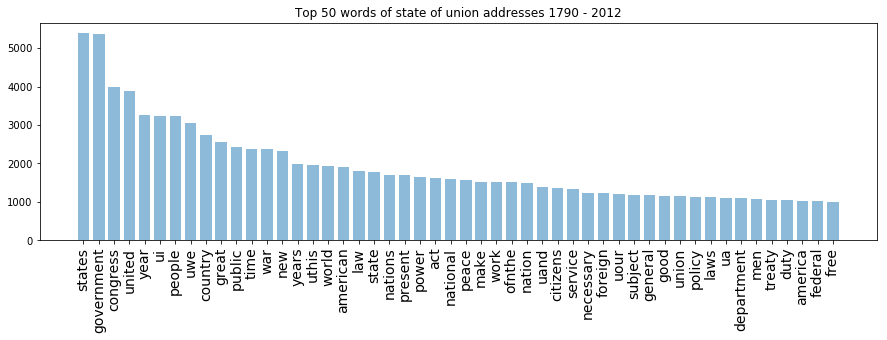

In [10]:
words_top50 = word_count.head(50)
fig, axes = plt.subplots(1,figsize=(15,4))
x= range(len(words_top50))
y = words_top50
plt.bar(x,y, width=0.75, alpha=0.5)
axes.set_title("Top 50 words of state of union addresses 1790 - 2012")
axes.set_xticks(x)
xtickNames = axes.set_xticklabels(words_top50.index)
plt.setp(xtickNames, rotation=90, fontsize=14)
plt.show()


#### Plot the number of sentences in speeches and average number of words per sentence over time
There is a gradual decrease in the average number of words per sentence in State of the Union speeches over time. Sentences are becoming drastically shorter. This may have occurred as it is easier to appeal to the masses by using short, powerful sentences that are easily comprehensible and will leave a lasting impression. This also shows how colloquial language in the US has evolved over time.

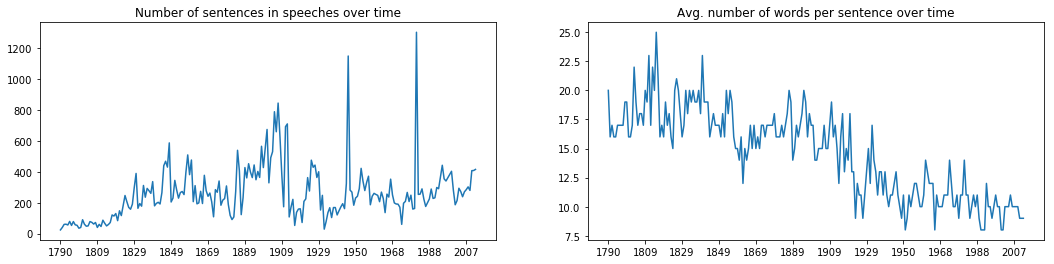

In [11]:
fig,axes = plt.subplots(1,2,figsize = (18,4))
n = len(su_Df)
x = range(n)
num_sentences = su_Df['num sentences'].values
avg_word_count = su_Df['avg words per sentence'].values
x_names = su_Df['year'].values

axes[0].plot(x,num_sentences)  
axes[0].set_title('Number of sentences in speeches over time')
axes[0].set_xticks(x[0:n:20])
axes[0].set_xticklabels(x_names[0:n:20])

axes[1].plot(x,avg_word_count)
axes[1].set_title('Avg. number of words per sentence over time')
axes[1].set_xticks(x[0:n:20])
axes[1].set_xticklabels(x_names[0:n:20])
plt.show()



#### Plot top 30 bigrams usage over time
United states together was used the most which is as one would expect.

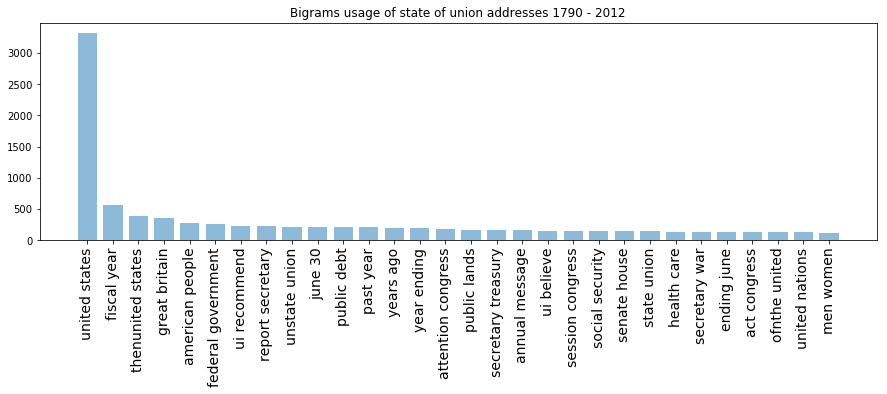

In [12]:
vec = CountVectorizer(stop_words='english',ngram_range=(2,2))
X = vec.fit_transform(tokens)
bigram_count = pd.DataFrame(X.todense(),columns = vec.get_feature_names()).sum(axis=0)
bigram_count = bigram_count.sort_values(ascending=False)

bigrams_top30 = bigram_count.head(30)
fig, axes = plt.subplots(1,figsize=(15,4))
x= range(len(bigrams_top30))
y = bigrams_top30
plt.bar(x,y, width=0.75, alpha=0.5)
axes.set_title("Bigrams usage of state of union addresses 1790 - 2012")
axes.set_xticks(x)
axes.set_xticklabels(bigrams_top30.index, rotation=90, fontsize=14)
plt.show()




#### Combining speeches of each president together

In [13]:
#grouped_df = su_Df.groupby('pres')
#pd.DataFrame(grouped_df.size().reset_index(name = "Group_Count"))
pres_df = su_Df.groupby('pres').agg({'year': lambda n :str(min(n))+ '-' +str(max(n)) ,'speech': sum, 'pres': np.size}).sort_values('year')
pres_df = pres_df.rename(columns={'pres':'speech_count'})
pres_df.head()


,speech,speech_count,year
pres,,,
George Washington,"[ugeorge, washingtonnjanuary, 8, 1790nnfellowc...",8,1790-1796
John Adams,"[unstate, union, addressnjohn, adamsnnovember,...",4,1797-1800
Thomas Jefferson,"[unstate, union, addressnthomas, jeffersonndec...",8,1801-1808
James Madison,"[unstate, union, addressnjames, madisonnnovemb...",8,1809-1816
James Monroe,"[unstate, union, addressnjames, monroendecembe...",8,1817-1824


#### No. of speeches by each president

From the plot it can be seen that the number of state of union addresses is equivalent to number of years of presidency in most of the cases. Only in few cases a speech was delivered twice in a same year (eg. George Washington)

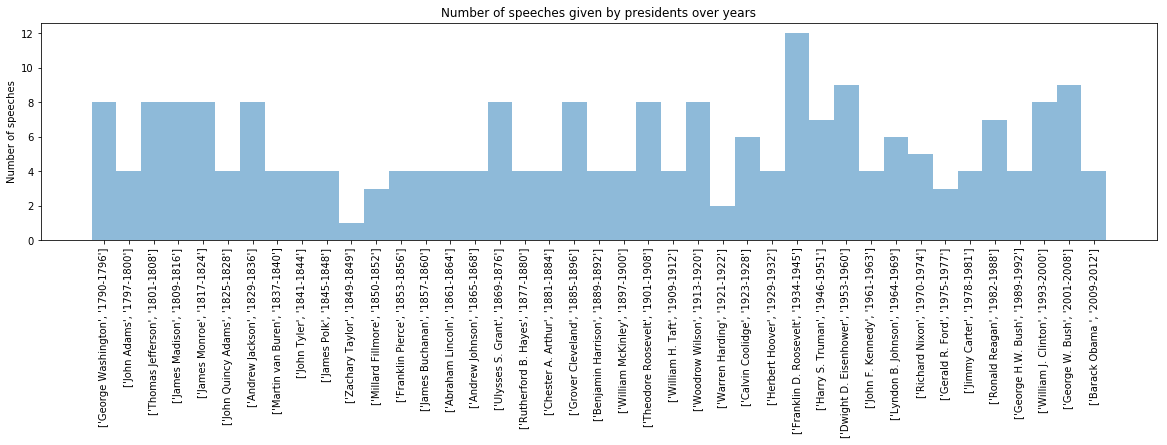

In [14]:

fig,axes = plt.subplots(1,figsize=(20,4))
x= range(len(pres_df))
y = pres_df.sort_values('year')['speech_count']
axes.bar(x,y,width = 1,alpha = 0.5)
axes.set_xticks(x)
  
titles=[]
for i in range(len(pres_df)):
    titles.append( [str(pres_df.index[i])] + [pres_df.year[i]])

axes.set_xticklabels(titles,rotation =90)
axes.set_title('Number of speeches given by presidents over years')
axes.set_ylabel('Number of speeches')

plt.show()


### Model - TF-IDF 
I have created a Term Frequency - Inverse Document Frequency matrix. This object is a matrix of the same dimensions as the Document Term Frequency matrix above, except each frequency has been normalized to the frequency of the term in the entire document. This gives additional weight to a term that is common in a given document, but comparably rare in the entire corpus. At the same time, terms that are common across many or all documents are penalized in frequency for any single document as they provide a smaller amount of unique information about a given document.

Once the frequencies are calculated, a square matrix of all documents is processed as a distance lookup for clustering. The documents have a large number of terms, which means that the distance exists in very high dimensional space. It is for this reason that distance is computed as cosine similarity rather than normal euclidean distance

In [15]:
pres_all=[]
for i in range(len(pres_df)):
     pres_all.append(' '.join(pres_df['speech'].values[i]))
        
tfVect = TfidfVectorizer(stop_words='english')
tfidf = tfVect.fit_transform(pres_all)
tfidf

<41x106037 sparse matrix of type '<type 'numpy.float64'>'
	with 279519 stored elements in Compressed Sparse Row format>

### Text clustering - Hierarchical 
An obvious point of interest is to view which presidents share the most in common with each other. That is, which presidents, as measured by the similarity of their speeches, speak congruently. To answer this question we’ll use a clustering algorithm called Hierarchical Clustering, which will create a dendrogram for easy visualization of this relationship. In agglomerative hierarchical clustering, each observation is initialized as its own cluster, and pairs of clusters are merged going up the hierarchy until all observations fall into one class.

The hierarchical cluster showes the cohesion among clusters at all levels since the 
hierarchical method preserves all intermediate clusters. I used the Ward Method of clustering to place a heavy weight on the cohesiveness of a formed cluster at each step of the process. The goal was to learn implicit features about groups of documents.


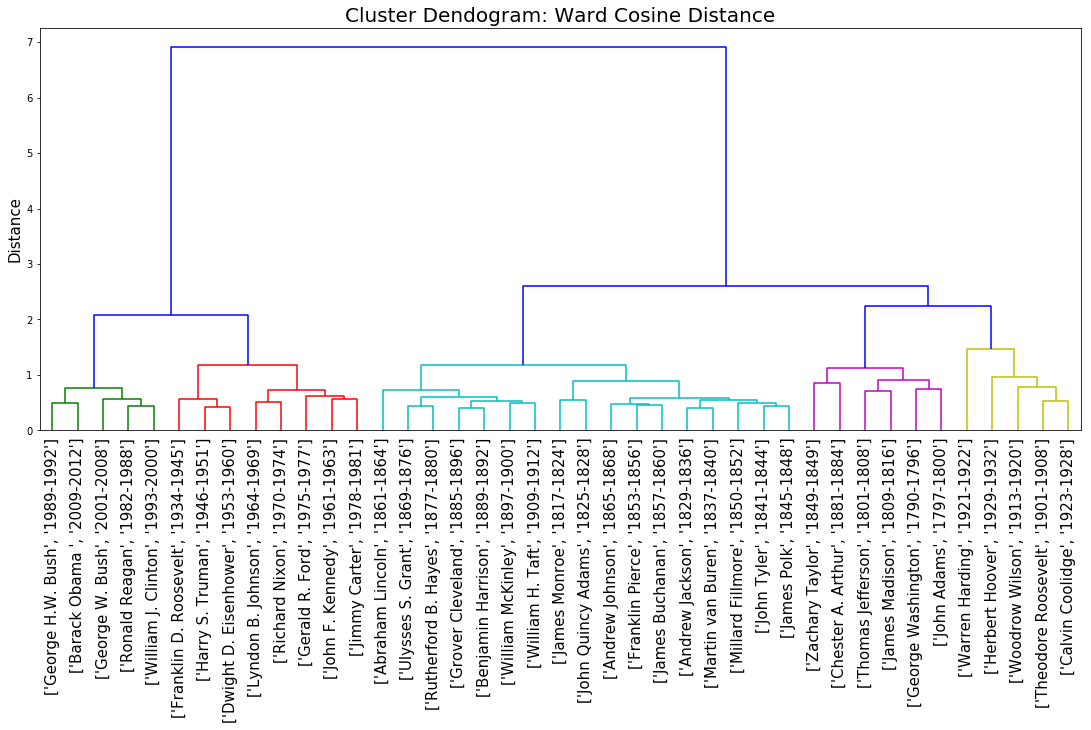

In [16]:
#define the linkage_matrix using ward clustering pre-computed distances

dist = 1 - cosine_similarity(tfidf)
linkage_matrix = linkage(dist,method = 'ward')
# seeing the last 4 distance.. 0 and 1 columns are indices that are clustered .. 2nd column is the distance.. 3rd column is cluster assigned           
#linkage_matrix[-4:,2]

fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(linkage_matrix, labels=titles,orientation='top',color_threshold=2,leaf_font_size=15);
#color_threshold. Colors all the descendent links below a cluster node kk the same color if kk is the first node below the cut threshold tt. A
#All links connecting nodes with distances greater than or equal to the threshold are colored blue.

plt.tight_layout() #show plot with tight layout
plt.ylabel('Distance',fontsize=15)
plt.title('Cluster Dendogram: Ward Cosine Distance',fontsize = 20)


plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters


assignments = fcluster(linkage_matrix,2,'distance')#fcluster(linkage_matrix,2,'maxclust')
h_cluster_output = pd.DataFrame({'pres':titles, 'cluster':assignments})
#plt.figure(figsize=(10, 8))
#plt.scatter(xs,ys ,c=assignments, cmap='prism')  # plot points with cluster dependent colors
#plt.show()

From this cluster dendrogram the first patterns are apparent and are as one might expect:
Speeches from the same Political Party and Era are commonly next to cluster 
- 1982 - 2012 Obama,Bush,Clinton,Reagan & Bush Sr...  - Recent 
- 1934 - 1981 Roosevelt,  Kennedy,Carter,Nixon..      - Post WW2
- 1901 - 1933 Rossevelt, Hoover Eisenhower & Truman.. - Pre WW2
- 1790 - 1900 Early further divided into 2 clusters

The most salient observation is that the most presidents appear to be clustered in a chronological manner. For example, on the far left we can see George W. Bush alongside Bill Clinton and Barrack Obama. This pattern permeates throughout the whole of the dendrogram

There appear to be a few major turning points in the State of the Union timeline where there are large, lasting shifts in the language used. In particular, the period until World War II form coherent blocks of time during which addresses are similar to each other but dissimilar from period after the Worls War II. [Huge jump in the dendogram]


### K-Means Clustering

In [17]:
n_clusters= 5
km = KMeans(n_clusters)
%time km.fit(tfidf)
clusters = km.labels_.tolist()


Wall time: 4.93 s


In [33]:
speech = {'pres': pres_df.index.values,'cluster': clusters}
frame = pd.DataFrame(speech,index = clusters)
terms = tfVect.get_feature_names()


In [34]:
from __future__ import print_function
tc={}
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind],end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['pres'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:
Cluster 0 words: states, government, united, congress, country, year, public, great, ui, people, war, time, subject, state, present, ofnthe, act, citizens, power, law,

Cluster 0 titles: Thomas Jefferson, James Madison, James Monroe, John Quincy Adams, Andrew Jackson, Martin van Buren, John Tyler, James Polk, Zachary Taylor, Millard Fillmore, Franklin Pierce, James Buchanan, Abraham Lincoln, Andrew Johnson, Ulysses S. Grant, Rutherford B. Hayes, Chester A. Arthur, Grover Cleveland, Benjamin Harrison, William McKinley,

Cluster 1 words: states, united, ugentlemen, public, government, country, gentlemen, house, treaty, war, great, peace, commerce, measures, representativesnni, citizens, article, congress, national, present,

Cluster 1 titles: George Washington, John Adams,

Cluster 2 words: uand, uwe, tonight, people, america, new, jobs, help, ui, budget, world, americans, years, american, work, year, make, know, time, congress,

Cluster 2 titles: Ronald Reagan, Ge

In [42]:
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [43]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Recent', 
                 1: 'Early2', 
                 2: 'Early1', 
                 3: 'Post WW2',
                 4: 'Pre WW2'}

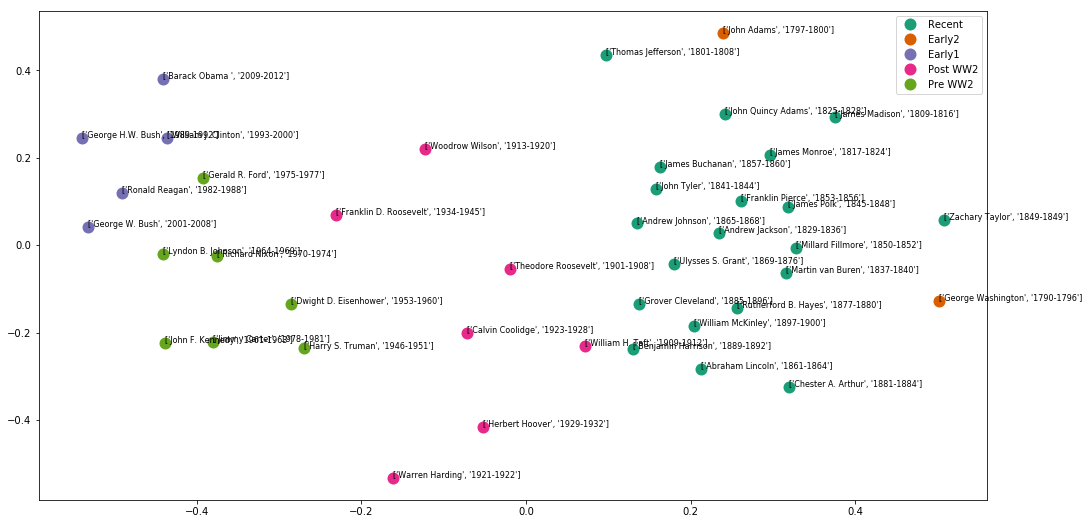

In [50]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
#group by cluster

groups = df.groupby('label')
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')

    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  
plt.show() #show the plot


### Comparison of Barack Obama, George Bush and Clinton Speeches

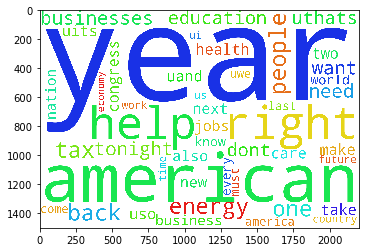

In [51]:

bo =pres_df.loc['Barack Obama ']['speech']
C= Counter(bo)
top= C.most_common(50)
w = [i[0] for i in top]
c = WordCloud(stopwords=STOPWORDS,background_color='white',width=2200,height=1500).generate(' '.join(w))
plt.imshow(c)


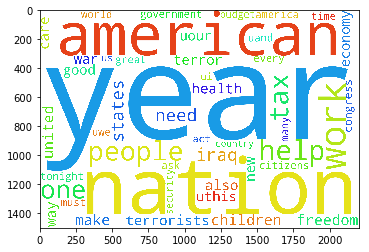

In [52]:
gb =pres_df.loc['George W. Bush']['speech']
C= Counter(gb)
top= C.most_common(50)
w = [i[0] for i in top]
c = WordCloud(stopwords=STOPWORDS,background_color='white',width=2200,height=1500).generate(' '.join(w))
plt.imshow(c)


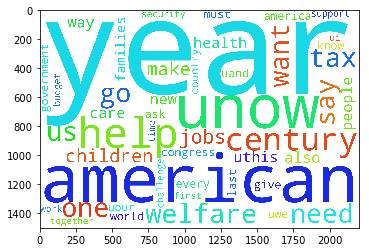

In [53]:
bc =pres_df.loc['William J. Clinton']['speech']
C= Counter(bc)
top= C.most_common(50)
w = [i[0] for i in top]
c = WordCloud(stopwords=STOPWORDS,background_color='white',width=2200,height=1500).generate(' '.join(w))
plt.imshow(c)


The salient topics in Barack Obama’s addresses are jobs, education, health,energy.
Looking at a few key topics, we see that Bill Clinton spoke a lot about kids and families compared to other recent presidents, George W. Bush spoke a lot about terrorism(freedom,Iraq,terror), and Barack Obama spoke a lot about jobs and businesses. 

The tone is markedly different at the other end of the spectrum in the modern era. Multiple terms related to time are apparent, like “year/years” and “time”. 

### Conclusion

Quick Recap:

- State of the Union Speeches are clustered chronologically, primarily into five groups.
- The presidential State of the Union speech largely reflects the time in which it is delivered.
- We learned the popular terms that help decide era of presidents.
- Sentences have, on average, gotten shorter over time.
